In [1]:
# for the model
from sequence_jacobian.examples.rbc import *

# for data generation
from sequence_jacobian.utilities.shocks import simulate
from sequence_jacobian.utilities.plotting import *

# for likelihood evaluation
import sequence_jacobian.estimation as sje

# various function imports from SSJ
from sequence_jacobian import create_model, ShockDict, AR, DensityModel

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pymc as mc
import arviz as az
import numpy as np
import pytensor as pt

In [3]:
# define the model here...

# or use the RBC model from the examples folder
blocks = [household, firm, mkt_clearing]
rbc_model = create_model(blocks, name="RBC")

In [4]:
# calibrated parameters
calibration = {
    "eis": 1.0,
    "frisch": 1.0,
    "delta": 0.025,
    "alpha": 0.11,
    "L": 1.0
}

In [5]:
# initial steady state values
unknowns_ss = {"vphi": 0.92, "beta": 1 / (1 + 0.01), "K": 2.0, "Z": 1.0}
targets_ss = {"goods_mkt": 0.0, "r": 0.01, "euler": 0.0, "Y": 1.0}

# solve the steady state for the given calibration
ss = rbc_model.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

In [6]:
unknowns = ["K", "L"]
targets = ["goods_mkt", "euler"]
exogenous = ["Z"]
outputs = ["K"]
T = 500

In [7]:
# define shocks using a shock dict object
shocks = ShockDict({
    "Z": AR(np.array([0.8]), 0.5)
})

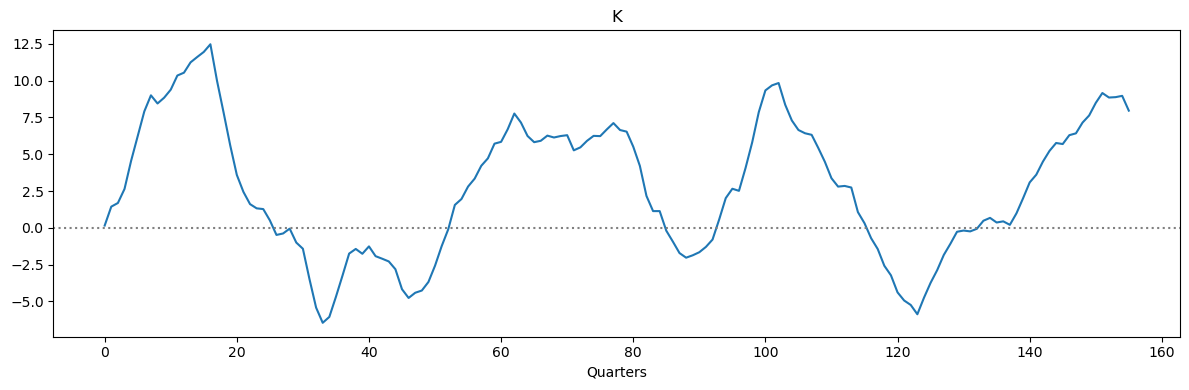

In [8]:
# generate fake data from the calibrated steady state
G = rbc_model.solve_jacobian(ss, unknowns, targets, exogenous, outputs, T=T)

impulses = shocks.generate_impulses(T)
irfs = {i: G @ {i: impulses[i]} for i in exogenous}

data_simul = simulate(list(irfs.values()), outputs, 156)
plt = plot_timeseries(data_simul, figsize=(12, 4))

In [9]:
def likelihood(model_params, phi_Z, sigma_Z, data, ss, model, jacobian):
    # reparameterize the model and recompute the Jacobian
    ss_new = ss.copy()
    ss_new.update(model_params)
    new_jacobian = model.solve_jacobian(
        ss_new, unknowns, targets, exogenous, outputs, T=500,
    )

    # reparameterize shocks
    shocks = ShockDict({
        "Z": AR(np.array([phi_Z]), sigma_Z)
    })

    # compute the log posterior likelihood
    return sje.log_likelihood(data, shocks, new_jacobian, outputs, exogenous, T=500)

In [10]:
# construct a log likelihood 
dsge_logpdf = DensityModel(
    data_simul, ss, rbc_model, likelihood,
    unknowns, targets, exogenous, T=500
)

In [11]:
with mc.Model() as rbc_test:
    # model params
    alpha = mc.Uniform("alpha", lower=0.01, upper=0.99)

    # Z shock params
    phi_Z = mc.Uniform("phi_Z", lower=0.01, upper=0.99)
    sigma_Z = mc.InverseGamma("sigma_Z", alpha=3, beta=1)

    likelihood = mc.Potential(
        "likelihood",
        dsge_logpdf(alpha, phi_Z, sigma_Z)
    )

    # choose MH for sake of efficiency and slice sampling for convergence to posterior
    chains = mc.sample(
        100,
        step = mc.Slice(),
        tune = 100,
        chains = 5
    )

Multiprocess sampling (5 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [phi_Z]
>Slice: [sigma_Z]


Output()

Sampling 5 chains for 100 tune and 100 draw iterations (500 + 500 draws total) took 979 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


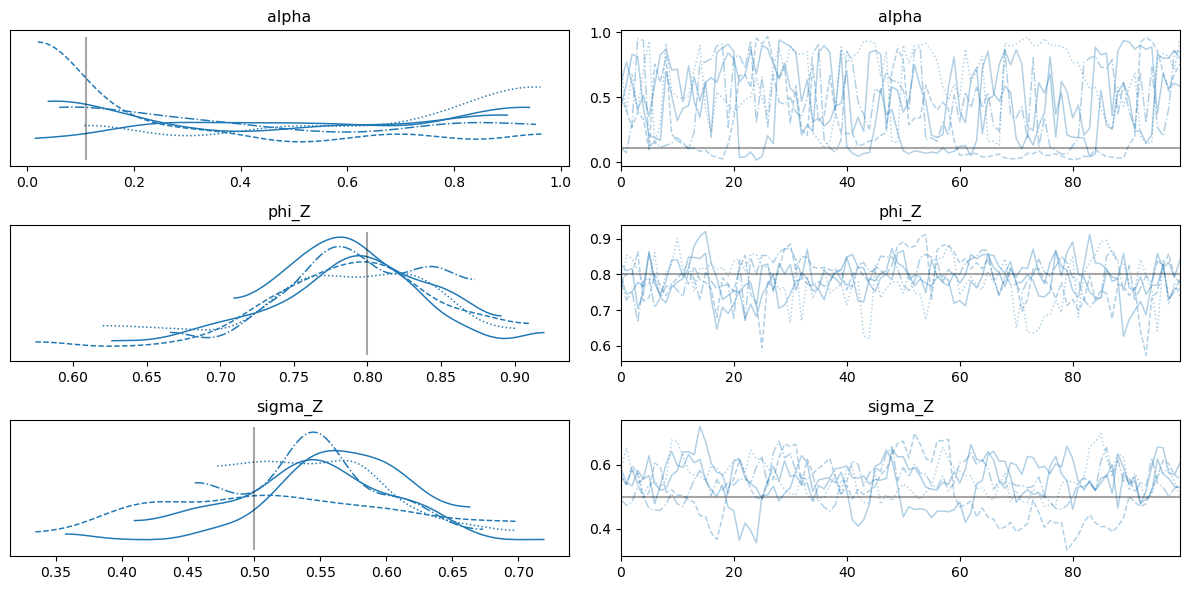

In [12]:
az.plot_trace(
    chains,
    lines = [
        ("alpha", {}, 0.11),
        ("phi_Z", {}, 0.8),
        ("sigma_Z", {}, 0.5)
    ],
)

mpl.tight_layout()